In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import gc
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path = '/home/tgeorgiopoulos/Downloads'

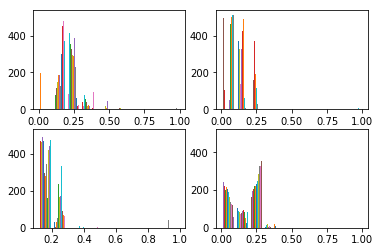

In [3]:
img1 = mpimg.imread(path+'/MURA-v1.1/train/XR_FINGER/patient03400/study1_positive/image2.png')
img2 = mpimg.imread(path+'/MURA-v1.1/train/XR_ELBOW/patient00011/study1_negative/image2.png')
img3 = mpimg.imread(path+'/MURA-v1.1/train/XR_HAND/patient00051/study1_negative/image1.png')
img4 = mpimg.imread(path+'/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png')

plt.subplot(221); plt.hist(img1)
plt.subplot(222); plt.hist(img2)
plt.subplot(223); plt.hist(img3)
plt.subplot(224); plt.hist(img4)
plt.show()


The images have grayscale values between 0 and 1. So, there is no need for rescaling.

In [4]:
# Reading the images from csv and creating a panda frame with the paths and the labels for each image.
train_df = pd.read_csv(path+'/MURA-v1.1/train_image_paths.csv',names = ['paths','label'])
valid_df = pd.read_csv(path+'/MURA-v1.1/valid_image_paths.csv',names = ['paths','label'])

for index, row in train_df.iterrows():
    if "positive" in train_df.iloc[index,0]:
        train_df.iloc[index,1] = 1
    elif "negative" in train_df.iloc[index,0]:
        train_df.iloc[index,1] = 0

for index, row in valid_df.iterrows():
    if "positive" in valid_df.iloc[index,0]:
        valid_df.iloc[index,1] = 1
    elif "negative" in valid_df.iloc[index,0]:
        valid_df.iloc[index,1] = 0
        
train_df['label'] = train_df['label'].astype(int)
valid_df['label'] = valid_df['label'].astype(int)

We apply data augmentation to the train dataset and convert all the images to (32,32) dimensions.

In [43]:
train_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization=True,
                                   rotation_range = 50, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1,
                                   zoom_range = 0.01, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory=path,
                                                    x_col='paths',
                                                    y_col='label',
                                                    has_ext=True,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    target_size=(50,50),
                                                    color_mode='rgb')

valid_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization = True,
                                   rotation_range = 0, 
                                   width_shift_range = 0., 
                                   height_shift_range = 0.,
                                   zoom_range = 0.0, 
                                   horizontal_flip = False,
                                  vertical_flip = False)

validation_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                                         directory=path,
                                                         x_col='paths',
                                                         y_col='label',
                                                         has_ext=True,
                                                         batch_size=32,
                                                         class_mode='binary',
                                                         shuffle=True,
                                                         target_size=(50,50),
                                                         color_mode='rgb')

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


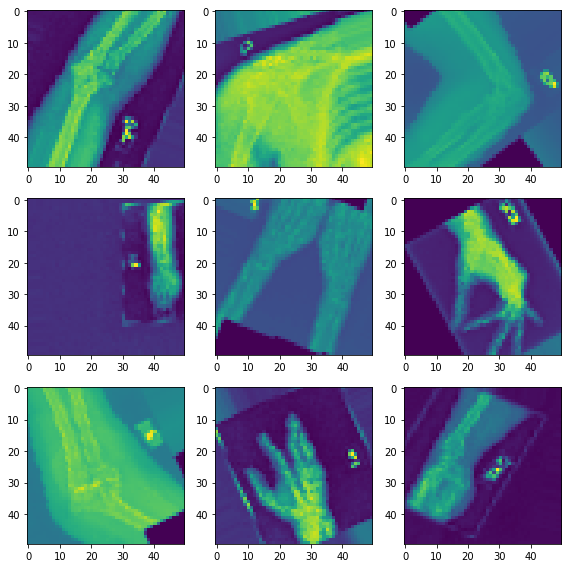

In [36]:
for data_batch, labels_batch in train_generator:
    plt.figure(figsize=(8, 8))
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        plt.imshow(data_batch[i,:,:,0])
    break    
plt.tight_layout()    

In [37]:
model_conv = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu",input_shape=(50, 50, 1)),
        tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu"),
        tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])

In [38]:
model = multi_gpu_model(model_conv, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=15,
                              steps_per_epoch=50,
                              validation_data=validation_generator,
                              validation_steps=5,
                              verbose=1)

Epoch 1/15
50/50 [==============================] - 5s 107ms/step - loss: 0.6897 - acc: 0.5707 - val_loss: 0.6889 - val_acc: 0.5375
Epoch 2/15
50/50 [==============================] - 5s 97ms/step - loss: 0.6835 - acc: 0.5819 - val_loss: 0.6962 - val_acc: 0.5437
Epoch 3/15
50/50 [==============================] - 5s 97ms/step - loss: 0.6734 - acc: 0.6062 - val_loss: 0.6949 - val_acc: 0.5437
Epoch 4/15
50/50 [==============================] - 5s 98ms/step - loss: 0.6719 - acc: 0.5906 - val_loss: 0.7043 - val_acc: 0.5437
Epoch 5/15
50/50 [==============================] - 5s 100ms/step - loss: 0.6731 - acc: 0.5988 - val_loss: 0.6899 - val_acc: 0.5437
Epoch 6/15
50/50 [==============================] - 5s 100ms/step - loss: 0.6653 - acc: 0.6062 - val_loss: 0.6892 - val_acc: 0.5437
Epoch 7/15
50/50 [==============================] - 5s 98ms/step - loss: 0.6717 - acc: 0.5963 - val_loss: 0.7132 - val_acc: 0.5437
Epoch 8/15
50/50 [==============================] - 5s 97ms/step - loss: 0.6697 

# VGG16

In [39]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

In [40]:
model = tf.keras.models.Sequential([
        conv_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='softmax')])

In [41]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [45]:
model = multi_gpu_model(model, gpus=2)
model.compile(tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=5,
                              steps_per_epoch=50,
                              validation_data=validation_generator)

Epoch 1/5
50/50 [==============================] - 18s 356ms/step - loss: 9.4957 - acc: 0.4044 - val_loss: 8.3128 - val_acc: 0.4786
Epoch 2/5
50/50 [==============================] - 15s 305ms/step - loss: 9.5565 - acc: 0.4006 - val_loss: 8.3128 - val_acc: 0.4786
Epoch 3/5
50/50 [==============================] - 15s 303ms/step - loss: 9.5256 - acc: 0.4025 - val_loss: 8.3128 - val_acc: 0.4786
Epoch 4/5
50/50 [==============================] - 15s 309ms/step - loss: 9.5555 - acc: 0.4006 - val_loss: 8.3128 - val_acc: 0.4786
Epoch 5/5
50/50 [==============================] - 15s 304ms/step - loss: 9.6950 - acc: 0.3919 - val_loss: 8.3128 - val_acc: 0.4786
